In [1]:
import pandas as pd
import numpy as np
import os
from prog.tools import *
from prog.model import *
import warnings
warnings.simplefilter("ignore")

In [2]:
aluminum_division = 12
random_state = 99

In [3]:
root = r"C:\Users\tzuli\Documents\python\teco"

input_ = {
    "model_id": "20230807120000000",
}
model_id = input_["model_id"]

# 取得train位置
train_path = os.path.join(root, "data", "train")        
os.makedirs(train_path, exist_ok = True)
data_csv    = os.path.join(train_path, "train_data.csv")
output_json = os.path.join(train_path, "output.json")

# 取得model位置
model_path = os.path.join(root, "data", "train", model_id)
os.makedirs(model_path, exist_ok = True)

model_detail = os.path.join(model_path, "model")
os.makedirs(model_detail, exist_ok = True)

In [4]:
df_raw = pd.read_csv(r"C:\Users\tzuli\Documents\python\teco\data\train\train_data.csv")
print(df_raw.shape)
df_raw.head(3)

(179, 16)


,日期,工號,序號,平衡轉速,初始_L側角度,初始_L側不平衡量,初始_F側角度,初始_F側不平衡量,平衡_L側角度,平衡_L側配重,平衡_F側角度,平衡_F側配重,最終_L側角度,最終_L側不平衡量,最終_F側角度,最終_F側不平衡量
0,2023-06-07,FC236001,1,1000,277.0,12.5,145.0,24.9,277.0,12.0,145.0,24.0,312,1.4,56,2.2
1,2023-06-07,FC236001,2,1000,312.0,1.4,56.0,2.2,312.0,1.0,146.0,2.0,304,1.8,98,1.1
2,2023-06-07,FC234613,1,1000,298.0,155.0,267.0,64.3,298.0,150.0,267.0,60.0,9,23.0,197,3.6


In [5]:
# df_all = df_raw.groupby("工號").first().reset_index(drop = True)
df_all = df_raw.query("(初始_L側不平衡量 >= 4) & (初始_F側不平衡量 >= 4)").reset_index(drop = True)
df_l = df_all[["初始_L側角度", "初始_L側不平衡量"]]
df_f = df_all[["初始_F側角度", "初始_F側不平衡量"]]
df_l.head(3)

,初始_L側角度,初始_L側不平衡量
0,277.0,12.5
1,298.0,155.0
2,15.0,111.0


In [6]:
angle_init = np.linspace(0, 360, (aluminum_division + 1)).astype(int)
print(f"angle_init = {angle_init}")

df_l = calculate_angle_proportion(df_l, angle_init, aluminum_division, side = "L")            
df_f = calculate_angle_proportion(df_f, angle_init, aluminum_division, side = "F")

angle_init = [  0  30  60  90 120 150 180 210 240 270 300 330 360]


In [7]:
df_l.head()

,初始_L側角度,初始_L側不平衡量,angle_proportion,angle_0,angle_target
0,277.0,12.5,0.233333,0.0,37
1,298.0,155.0,0.066667,0.0,37
2,15.0,111.0,0.500000,0.0,55
3,3.0,24.7,0.100000,0.0,37
4,16.0,137.0,0.466667,0.0,55


In [8]:
df_f.head()

,初始_F側角度,初始_F側不平衡量,angle_proportion,angle_0,angle_target
0,145.0,24.9,0.166667,0.0,37
1,267.0,64.3,0.100000,0.0,37
2,165.0,30.2,0.500000,0.0,55
3,140.0,4.7,0.333333,0.0,55
4,10.0,76.7,0.333333,0.0,55


In [9]:
df_l = calculate_weight(df_l, side = "L")
df_f = calculate_weight(df_f, side = "F")

In [10]:
df_l.head()

,初始_L側角度,初始_L側不平衡量,angle_proportion,angle_0,angle_target,3_raw,7_raw,5_raw,10_raw,3_full,...,7,5,10,3_solution,7_solution,5_solution,10_solution,37_delta,5_delta,10_delta
0,277.0,12.5,0.233333,0.0,37,4.0,9.0,6.0,12.0,0.0,...,9,6,12,{'4': '1'},"{'4': '1', '5': '1'}",{'6': '1'},"{'5': '1', '7': '1'}",0.0,0.0,0.0
1,298.0,155.0,0.066667,0.0,37,46.0,108.0,78.0,155.0,0.0,...,52,22,43,"{'6': '1', '20': '2'}","{'16': '2', '20': '1'}","{'6': '1', '16': '1'}","{'7': '1', '16': '1', '20': '1'}",0.0,0.0,0.0
2,15.0,111.0,0.500000,0.0,55,33.0,78.0,56.0,111.0,0.0,...,22,0,55,"{'6': '1', '7': '1', '20': '1'}","{'6': '1', '16': '1'}",{},"{'7': '1', '16': '3'}",0.0,0.0,0.0
3,3.0,24.7,0.100000,0.0,37,7.0,17.0,12.0,25.0,0.0,...,17,12,25,{'7': '1'},"{'4': '1', '6': '1', '7': '1'}","{'5': '1', '7': '1'}","{'5': '1', '20': '1'}",0.0,0.0,0.0
4,16.0,137.0,0.466667,0.0,55,41.0,96.0,68.0,137.0,0.0,...,40,12,25,"{'5': '1', '16': '1', '20': '1'}",{'20': '2'},"{'5': '1', '7': '1'}","{'5': '1', '20': '1'}",0.0,0.0,0.0


In [11]:
df_f.head()

,初始_F側角度,初始_F側不平衡量,angle_proportion,angle_0,angle_target,3_raw,7_raw,5_raw,10_raw,3_full,...,7,5,10,3_solution,7_solution,5_solution,10_solution,37_delta,5_delta,10_delta
0,145.0,24.9,0.166667,0.0,37,7.0,17.0,12.0,25.0,0.0,...,17,12,25,{'7': '1'},"{'4': '1', '6': '1', '7': '1'}","{'5': '1', '7': '1'}","{'5': '1', '20': '1'}",0.0,0.0,0.0
1,267.0,64.3,0.100000,0.0,37,19.0,45.0,32.0,64.0,0.0,...,45,32,8,"{'5': '1', '7': '2'}","{'5': '1', '20': '2'}",{'16': '2'},{'4': '2'},0.0,0.0,0.0
2,165.0,30.2,0.500000,0.0,55,9.0,21.0,15.0,30.0,0.0,...,21,15,30,"{'4': '1', '5': '1'}","{'5': '1', '16': '1'}","{'4': '2', '7': '1'}","{'7': '2', '16': '1'}",0.0,0.0,0.0
3,140.0,4.7,0.333333,0.0,55,1.0,3.0,2.0,5.0,0.0,...,4,0,5,{},{'4': '1'},{},{'5': '1'},0.0,-2.0,0.0
4,10.0,76.7,0.333333,0.0,55,23.0,54.0,38.0,77.0,0.0,...,54,38,21,"{'7': '1', '16': '1'}","{'7': '2', '20': '2'}","{'6': '1', '16': '2'}","{'5': '1', '16': '1'}",0.0,0.0,0.0


In [12]:
df_l[["37_delta", "5_delta", "10_delta"]].describe()

,37_delta,5_delta,10_delta
count,97.000000,97.000000,97.000000
mean,-0.072165,0.000000,-0.030928
std,0.665323,0.456435,0.304604
min,-2.000000,-2.000000,-2.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [13]:
df_f[["37_delta", "5_delta", "10_delta"]].describe()

,37_delta,5_delta,10_delta
count,97.000000,97.000000,97.000000
mean,-0.154639,-0.051546,-0.010309
std,0.740780,0.441851,0.176473
min,-2.000000,-2.000000,-1.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [14]:
df_l1 = encoding(df_l, side = "L")
df_f1 = encoding(df_f, side = "F")

In [15]:
X_train_l, X_test_l, y_train_l, y_test_l = split_data(df_l1, random_state)
X_train_f, X_test_f, y_train_f, y_test_f = split_data(df_f1, random_state)

In [16]:
X_train_l.head()

,angle_proportion,angle_0,3,7,37_delta,5,5_delta,10,10_delta
22,0.266667,0.0,0.000000,0.888889,0.0,0.000000,-2.0,0.888889,0.0
91,0.500000,0.0,0.299065,0.177570,0.0,0.504673,0.0,0.476636,0.0
26,0.000000,1.0,0.300971,0.155340,0.0,0.504854,0.0,0.456311,0.0
27,0.366667,0.0,0.300000,0.041176,0.0,0.170588,0.0,0.000000,-2.0
41,0.366667,0.0,0.302326,0.697674,0.0,0.511628,0.0,1.000000,0.0


In [17]:
X_train_f.head()

,angle_proportion,angle_0,3,7,37_delta,5,5_delta,10,10_delta
19,0.166667,0.0,0.299270,0.291971,0.0,0.087591,0.0,0.182482,0.0
83,0.333333,0.0,0.294118,0.705882,0.0,0.500000,0.0,1.000000,0.0
27,0.000000,1.0,0.294872,0.705128,0.0,0.500000,0.0,0.282051,0.0
35,0.466667,0.0,0.299824,0.705467,0.0,0.493827,0.0,0.000000,-1.0
92,0.433333,0.0,0.000000,0.714286,-2.0,0.571429,0.0,1.000000,0.0


In [18]:
models_l = modeling(X_train_l, y_train_l, random_state)
scores_l, pred_trains_l, pred_tests_l = calculate_score(models_l, X_train_l, X_test_l, y_train_l, y_test_l, scoring = "weighted", cv_flag = 1)

models_f = modeling(X_train_f, y_train_f, random_state)
scores_f, pred_trains_f, pred_tests_f = calculate_score(models_f, X_train_f, X_test_f, y_train_f, y_test_f, scoring = "weighted", cv_flag = 1)

In [19]:
scores_l

accuracy      precision       recall         f1      accuracy
                    train test     train  test  train test train test       cv
Bayes (Gaussian)     0.96  0.9      0.96  0.92   0.96  0.9  0.96  0.9     0.86
Random Forest        1.00  1.0      1.00  1.00   1.00  1.0  1.00  1.0     1.00

In [20]:
scores_f

accuracy      precision       recall         f1        \
                    train test     train  test  train test train  test   
Bayes (Gaussian)     0.71  0.8      0.81  0.85   0.71  0.8  0.66  0.78   
Random Forest        1.00  1.0      1.00  1.00   1.00  1.0  1.00  1.00   

                 accuracy  
                       cv  
Bayes (Gaussian)     0.68  
Random Forest        1.00

In [21]:
scores_l.to_csv(os.path.join(model_path, "L_score.csv"))
scores_f.to_csv(os.path.join(model_path, "F_score.csv"))

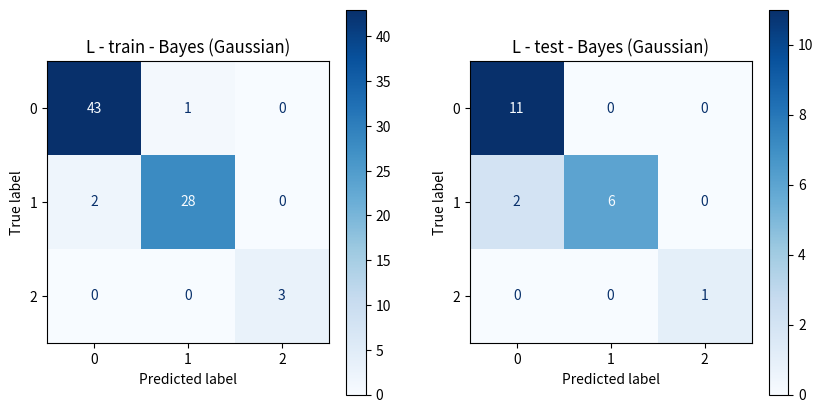

Classification Report of L Test:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.75      0.86         8
           2       1.00      1.00      1.00         1

    accuracy                           0.90        20
   macro avg       0.95      0.92      0.92        20
weighted avg       0.92      0.90      0.90        20

----------------------------------------------------------------------------------------------------


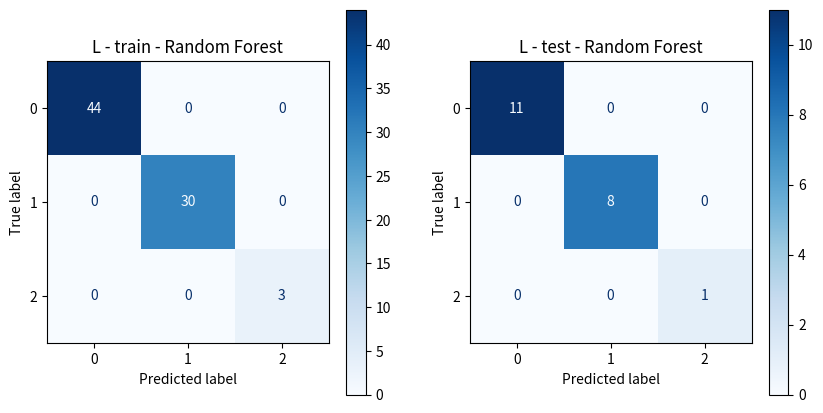

Classification Report of L Test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

----------------------------------------------------------------------------------------------------


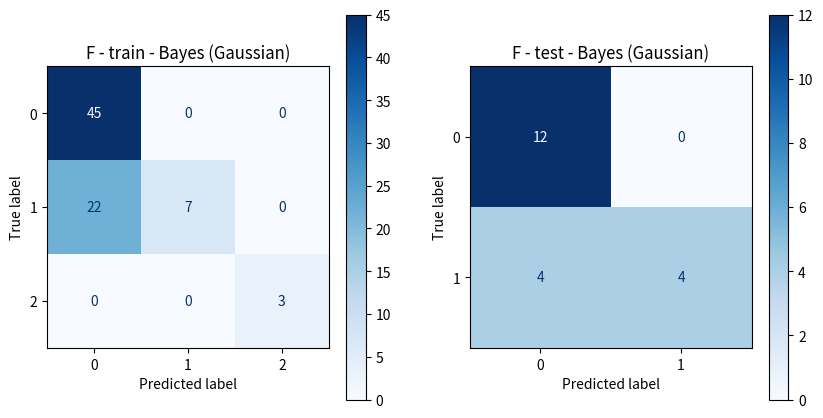

Classification Report of F Test:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.50      0.67         8

    accuracy                           0.80        20
   macro avg       0.88      0.75      0.76        20
weighted avg       0.85      0.80      0.78        20

----------------------------------------------------------------------------------------------------


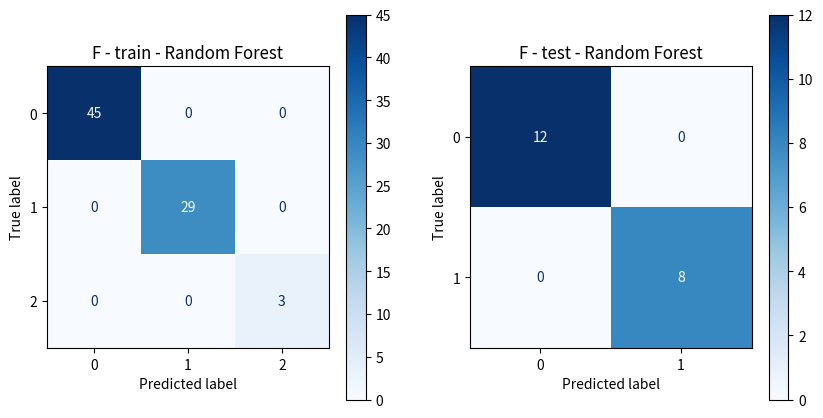

Classification Report of F Test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

----------------------------------------------------------------------------------------------------


In [22]:
pred_plot(y_train_l, y_test_l, pred_trains_l, pred_tests_l, scores_l, model_path, side = "L", flag = True)
pred_plot(y_train_f, y_test_f, pred_trains_f, pred_tests_f, scores_f, model_path, side = "F", flag = True)